In [32]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime
import math
from itertools import combinations
from itertools import islice
from IPython.display import Image
from IPython.core.display import HTML
import networkx as nx
import seaborn as sns
import ast
import itertools
from collections import defaultdict

# 02807 Final Project 
# User-Based Movie Recommendation System
By *Xueying CHEN (s216410)*, *Kewei DU (s220059)*, *Renjue SUN (s181294)* and *Jingxin ZHANG (s212658)*

## Data-set description

Our data-set is named MovieLens ([url to data-set](https://grouplens.org/datasets/movielens/)). We chose this data-set for its sufficent amount of data and some already existing recommendation systems research is based on it for us to refer. The raw data-set contains more than 25 million movie ratings from more than 160 thousand users. In order to save the computational power, we decided to sample approximately a quarter of the total users to make our own data-set for the project.

## Data Pre-processing

### User Sampling

**How did we sample users?**

The original data-set contains the rating information for more than 160 thousand users which is extremely large and needs much computational power to process. We decided to sample from the original data-set to reduce the number of selected users to around 40 thousand, which is approximately a quarter of the initial number of users in the raw data-set.

It can be seen from the figure above that more than half of our selected users rated less than 100 movies and only quite few selected users rated more than 1000 movies. The distribution of the number of movies that each selected user rated roughly follows *exponential distribution* which is also the trend we observed in the original data-set. Therefore we sampled users from $10^0$, $10^1$, $10^2$, $10^3$ to $10^4$ pairwise to keep approximately a quarter of users in each segment.

In [15]:
file_path = '../Data/'  # current root
file_name = 'ratings.csv'  # the name of csv file

In [16]:
ratings = pd.read_csv(file_path + file_name)
total_users = sorted(list(set(ratings['userId'])))  # sorted total userIds
print('the total number of users in the raw data-set: {}'.format(len(total_users)))

the total number of users in the raw data-set: 162541


In [12]:
print('the total number of movie ratings in the raw data-set: {}'.format(len(ratings)))

the total number of movie ratings in the raw data-set: 25000095


In [33]:
data_file_path = "../Data/";
data_file_name = "ratings.csv";

dest_data_file_name = "Sampled User Dataset.csv";

In [34]:
random_seed = 2807;

In [35]:
def sample_df(df, bin_points, sample_portion) :
    dist = df.userId.value_counts(sort=True, ascending=True);
    sampled_dist = [];

    for (idx, bin_point) in enumerate(bin_points) :
        if idx == len(bin_points) - 1 :
            break;

        binned_dist = dist[(dist > bin_points[idx]) & (dist <= bin_points[idx + 1])];

        np.random.seed(random_seed);
        sampled_dist.append(
            np.random.choice(binned_dist.index, int(len(binned_dist) * sample_portion), replace=False)
        );

    return sampled_dist;

In [36]:
def create_df_from_sampled_dist(original_df, sampled_dist) :
    sampled_df = pd.DataFrame(columns=original_df.columns);

    for sampled_dist_element in sampled_dist:
        sampled_df = pd.concat([sampled_df, original_df[original_df.userId.isin(sampled_dist_element)]]);

    return sampled_df;

In [37]:
bin_points = [1, 10, 100, 1000, 10000];
sampled_portion = 0.25;

In [38]:
sampled_csv = create_df_from_sampled_dist(ratings, sample_df(ratings, bin_points, sampled_portion));

In [ ]:
sampled_csv.to_csv(dest_data_file_name);

In [39]:
file_path = '../Data/'  # current root
file_name = 'Sampled User Dataset.csv'  # the name of csv file

In [40]:
df = pd.read_csv(file_path + file_name)
df['date'] = pd.to_datetime(df['timestamp'], unit='s')  # add a new date column

In [42]:
users = sorted(list(set(df['userId'])))  # sorted selected userIds
print('the number of selected users: {}'.format(len(users)))
print('the number of selected movie ratings: {}'.format(len(df)))

the number of selected users: 40634
the number of selected movie ratings: 6182195


In [ ]:
num_movies = []  # the number of movies each user has rated 
for i in users:
    num_movies.append(len(df[df['userId'] == i])) 
# print(len(num_movies))

In [44]:
print('the minimal number of movies rated by selected users: {}'.format(min(num_movies)))
print('the maximal number of movies rated by selected users: {}'.format(max(num_movies)))

the minimal number of movies rated by selected users: 20
the maximal number of movies rated by selected users: 7488


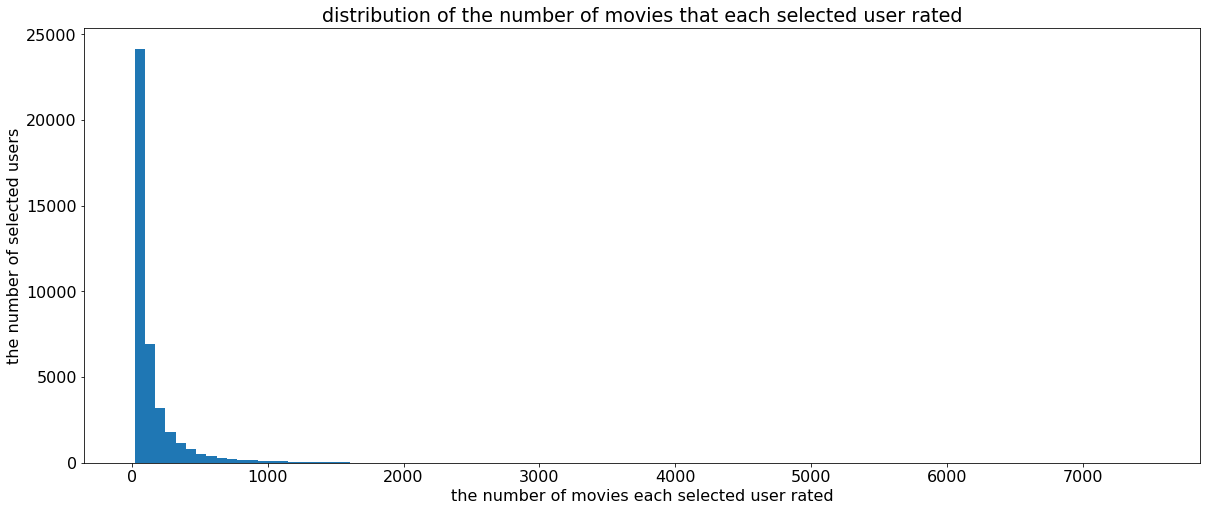

In [16]:
bins = np.linspace(min(num_movies), max(num_movies), 100)
# print(np.floor(bins))
plt.figure(figsize = (20, 8))
plt.rc('font', size=16)
plt.hist(num_movies, bins)
plt.title('distribution of the number of movies that each selected user rated')
plt.xlabel('the number of movies each selected user rated')
plt.ylabel('the number of selected users')
plt.show()

### Movie Average Rating
The average ratings of each movie are saved in a *.csv* file for further use.

In [45]:
df_movie_rating = df.groupby(['movieId'])['rating'].mean();

In [21]:
df_movie_rating.to_csv("../Data/average_rating.csv");

### Movie Genre Correlation
The correlation between genres are calculated via the occurence of genre pairs. The correlation matrix of genres is saved in a *.csv* file for further use.

In [46]:
movie_file_name = "movies.csv";

In [47]:
df_movie = pd.read_csv(file_path+movie_file_name, sep=",", engine="python");
df_movies = pd.read_csv(file_path+movie_file_name, sep=",", engine="python");

In [48]:
df_movie["genres_list"] = df_movie["genres"].apply(lambda x: x.split('|'));

In [49]:
def find_combination(list, dict) :
    list.sort(reverse=False);

    for combination in itertools.combinations(list, 2) :
        if (combination not in dict.keys()) :
            dict[combination] = 0;

        dict[combination] += 1;

In [ ]:
combination_occurrence_dict = {};

genre_list = list(set(x for l in df_movie["genres_list"].tolist() for x in l));
genre_list.sort(reverse=False);

df_movie["genres_list"].apply(lambda x: find_combination(x, combination_occurrence_dict))

# print(genre_list)
# print(combination_occurrence_dict)

In [53]:
sorted_combination_occurrence_dict = dict(sorted(combination_occurrence_dict.items()));

In [54]:
combination_occurrence_nested_dict = defaultdict(dict)
for ((p, q), value) in sorted_combination_occurrence_dict.items():
    combination_occurrence_nested_dict[p][q] = value
    combination_occurrence_nested_dict[q][p] = value

df_genre_occurrence = pd.DataFrame(combination_occurrence_nested_dict).sort_index()

### fill diagonal elements with zeros
np.fill_diagonal(df_genre_occurrence.values, 0)
df_genre_occurrence = df_genre_occurrence.replace(np.nan, 0);

In [55]:
df_genre_correlation = df_genre_occurrence.corr()

In [ ]:
df_genre_correlation.to_csv("../Data/genre_correlation.csv");

## Phase 1
### Build up an averge rating dictionary in which userId is as the key and averge rating based on all movies rated by the user is as the value.

MapReduce operation with a figure below for detailed explanation:
- input: the input is all movie_id and user_id pairs in the form of (movie_id X, user_id X)
- splitting: all pairs are splitted into different groups
- mapping: each pair is mapped with its corresponding rating within splitted groups
- shuffling: ratings are shuffled according to user_id and now ratings with the same user_id are in the same group 
- reducing: calculate the average rating of each group
- output: combine the reducing result of each group

In [24]:
Image(url="https://i.postimg.cc/fyWLPnzk/average-rating.png")

In [22]:
# calculate the average rating of each user
avg_rating = []
for i in users: 
    # print(i)
    # print('**********************************')
    user_ratings = list(df[df['userId'] == i]['rating'])
    avg_rating.append(sum(user_ratings) / len(user_ratings))

In [23]:
# average rating dictionary
avg_rating_dict = {}
counter = 0
for i in users:
    avg_rating_dict[i] = avg_rating[counter]
    counter += 1

## Phase 2
### Generate all combinations of user pairs.
MapReduce operation with a figure below for detailed explanation: 
- input: the input is the output of Phase 1 in the form of (user_id X, avg_rating)
- splitting: splitting all input values into different groups
- mapping: mapping each input value with the total number of users (user_count) within splitted groups
- shuffling: each user_id is paired with all other ids and user pairs share one same user_id form new groups
- reducing: reducing by user_id as the key and the total number of users (user_count) as the value
- output: combine the reducing result of each group

In [25]:
Image(url="https://i.postimg.cc/43bXRLFc/user-pairs.png")

In [10]:
user_pairs = list(combinations(users, 2))
# user_pairs

## Phase 3
### Calculate the similarity of all user pairs. Build up a pair similarity dictionary in which user pair is as the key and cosine similarity and the number of movies rated by users of the user pair is as the value. If no movie is rated by both users of the user pair, the value is None. 
The following formula is used for calculating cosine similarity:
$$
sm_{ij} = \frac{\sum_{l \in L_{ij}} r_{il} \cdot r_{jl}}{\sqrt{\sum_{l \in L_{ij}} r_{il}^2} \cdot \sqrt{\sum_{l \in L_{ij}} r_{jl}^2}}
$$
Where: 
- $L_{ij}$ is the movies which are rated by both user $i$ and user $j$;
- $r_{il}$ is the rating of a single movie $l$ from user $i$;
- $r_{jl}$ is the rating of a single movie $l$ from user $j$;
- $sm_{ij}$ is the cosine similarity between user $i$ and user $j$.

MapReduce operation with a figure below for detailed explanation:
- input: all movies rated by user_id i, their ratings and a specific user pair <user_id i, user_id j>
- splitting: splitting all input values into different groups for distributed computing
- mapping: emitting a dictionary containing all movies rated by user_id j and their ratings; according to the input, such dictionary for user_id i is also ready
- shuffling: <user_id i, user_id j> is as the key and all movies rated by both user_id i and user_id j and their ratings from both users are prepared for the reducer
- reducing/output: calculating the similarity score of user_id i and user_id j according to the formula above

By conducting the described MapReduce operation for all user pairs, the similarity scores of them can be calculated. 

In [26]:
Image(url="https://i.postimg.cc/43ZTPvNx/similarity.png")

In [24]:
# function to find common members
def common_member(a, b):   
    a_set = set(a)
    b_set = set(b)
     
    # check length
    if len(a_set.intersection(b_set)) > 0:
        return(a_set.intersection(b_set)) 
    else:
        return("no common elements")

In [ ]:
pair_similarity_dict = {}

# for i in range(len(user_pairs)):  # iterate all user pairs 
for i in range(len(users) - 1):  # iterate all user pairs for userId 9
    user_1_movies = list(df[df['userId'] == user_pairs[i][0]]['movieId'])
    user_2_movies = list(df[df['userId'] == user_pairs[i][1]]['movieId'])
    overlapping_movies = common_member(user_1_movies, user_2_movies)
    
    if overlapping_movies == "no common elements":
        pair_similarity_dict[user_pairs[i]] = None
    else:    
        user_1_rating = []
        user_2_rating = []

        for j in overlapping_movies:
            user_1_extraction = df[(df['userId'] == user_pairs[i][0]) & (df['movieId'] == j)]['rating'].to_numpy()[0]
            user_2_extraction = df[(df['userId'] == user_pairs[i][1]) & (df['movieId'] == j)]['rating'].to_numpy()[0]
            user_1_rating.append(user_1_extraction)
            user_2_rating.append(user_2_extraction)

        user_1_rating = np.array(user_1_rating)
        user_2_rating = np.array(user_2_rating)

        pair_similarity = (np.sum(user_1_rating * user_2_rating)) / (np.sqrt(np.sum(user_1_rating **2)) * np.sqrt(np.sum(user_2_rating **2)))
        pair_similarity_dict[user_pairs[i]] = [pair_similarity, len(overlapping_movies)]
        
    print(i)
    print(pair_similarity_dict[user_pairs[i]])
    print('****************************************')

In [104]:
print('the smallest userId: {}'.format(users[0]))
print('the largest userId: {}'.format(users[-1]))
print('the number of total users: {}'.format(len(users)))
print('the first user pair for userId 9: {}'.format(user_pairs[0]))
print('the last user pair for userId 9: {}'.format(user_pairs[40632]))
print('the similarity & shared rated movies of the first user pair for userId 9: {}'.format(pair_similarity_dict[user_pairs[0]]))
print('the similarity & shared rated movies of the last user pair for userId 9: {}'.format(pair_similarity_dict[user_pairs[40632]]))

the smallest userId: 9
the largest userId: 162538
the number of total users: 40634
the first user pair for userId 9: (9, 10)
the last user pair for userId 9: (9, 162538)
the similarity & shared rated movies of the first user pair for userId 9: [0.9694866044752414, 12]
the similarity & shared rated movies of the last user pair for userId 9: [0.9531346798757712, 14]


For the concern of saving computational power, we only ran the code for all user pairs with userId 9 and thus userId 9 is our representative user and target user to recommend movies to. By enabling the line of code for iterating all user pairs, the similarity score of all user pairs can be easily calculated. 

## Phase 4
### Recommend movies to a specific user.

In [131]:
select_rating = avg_rating_dict[users[0]]  # the average rating of userId 9

In [111]:
# select a specific user to recommend movies for him/her
# input a userId in users 
# output user pairs of the selected user
def select_a_user(userId):
    select_pair = []
    for pair in user_pairs:
        if (((pair[0] == userId) & (pair[1] != userId)) or ((pair[0] != userId) & (pair[1] == userId))):
            select_pair.append(pair)
    return select_pair

In [127]:
select_pair = select_a_user(users[0])  # select the user with smallest userId 9

In [134]:
# similarity dictionary of the selected user pairs 
select_pair_similarity_dict = dict((k, pair_similarity_dict[k]) for k in select_pair if k in pair_similarity_dict)

In [139]:
# discard None value in the similarity dictionary of the selected user
select_similarity_not_none_dict = {k: v for k, v in select_pair_similarity_dict.items() if v is not None}

In [143]:
# sort the dictionary according to similarity score
sorted_dict = dict(sorted(select_similarity_not_none_dict.items(), key=lambda item: item[1][0], reverse=True))

{(9, 10593): [1.0000000000000002, 2],
 (9, 24532): [1.0000000000000002, 3],
 (9, 29618): [1.0000000000000002, 2],
 (9, 37814): [1.0000000000000002, 3],
 (9, 73334): [1.0000000000000002, 3],
 (9, 89486): [1.0000000000000002, 5],
 (9, 97292): [1.0000000000000002, 3],
 (9, 120929): [1.0000000000000002, 2],
 (9, 148569): [1.0000000000000002, 2],
 (9, 68): [1.0, 1],
 (9, 88): [1.0, 1],
 (9, 154): [1.0, 1],
 (9, 283): [1.0, 1],
 (9, 365): [1.0, 1],
 (9, 383): [1.0, 1],
 (9, 413): [1.0, 1],
 (9, 444): [1.0, 1],
 (9, 505): [1.0, 1],
 (9, 657): [1.0, 1],
 (9, 679): [1.0, 2],
 (9, 750): [1.0, 1],
 (9, 843): [1.0, 1],
 (9, 1039): [1.0, 1],
 (9, 1272): [1.0, 1],
 (9, 1345): [1.0, 1],
 (9, 1353): [1.0, 1],
 (9, 1560): [1.0, 1],
 (9, 1750): [1.0, 3],
 (9, 1983): [1.0, 1],
 (9, 2000): [1.0, 1],
 (9, 2008): [1.0, 1],
 (9, 2085): [1.0, 1],
 (9, 2156): [1.0, 1],
 (9, 2170): [1.0, 1],
 (9, 2175): [1.0, 1],
 (9, 2186): [1.0, 1],
 (9, 2274): [1.0, 1],
 (9, 2281): [1.0, 1],
 (9, 2288): [1.0, 1],
 (9, 2303):

### A problem in the algorithm

**Apart from cosine similarity value, we also consider the number of shared ratings between our target user and his/her neighbors.**

According to the sorted similarity score of user pairs in descending order printed above, most of user pairs possess high similarity measure have few common ratings and many of them only shared one rating. 

If there is only very few shared ratings between two users, even though their cosine similarity value is high, they might still be quite different in regards of movie preference.

In response to this concern, we hereby only take user pairs have equal to or more than 100 shared ratings to the selection phase of top users. However, it is doable here for userId 9 rated many movies. For some users only rated few movies, this hard-coded approach cannot work out.  

**Consider only taking neighbors have more than half of the target user's rated movies shared? Better approach to solve this issue?**

In [159]:
top_similarity_user_dict = {}
for key, value in sorted_dict.items():
    if value[1] >= 100:  # they have shared rating of at least 100 movies
        top_similarity_user_dict[key] = value

In [164]:
print('the number of users meeting the criteria that he/she has at least 100 shared rating with userId 9: {}'.format(len(top_similarity_user_dict)))

the number of users meeting the criteria that he/she has at least 100 shared rating with userId 9: 326


The filtered dictionary of similarity score and the number of shared ratings of user pairs is printed below in descending order of similarity measure. It is filtered on the criteria that the number of shared ratings is equal to or more than 100.

In [161]:
top_similarity_user_dict  # userId 161383 is the top 1 user 

{(9, 161383): [0.9762951640732068, 120],
 (9, 46202): [0.974996988007467, 101],
 (9, 17777): [0.9728728501889217, 100],
 (9, 132236): [0.9727561245725197, 141],
 (9, 97997): [0.9698647793959986, 122],
 (9, 6618): [0.968951292142123, 114],
 (9, 119259): [0.968188511203004, 114],
 (9, 45956): [0.9680484186702294, 101],
 (9, 50959): [0.9671802039764784, 126],
 (9, 151449): [0.9668720558400058, 103],
 (9, 40595): [0.9663111503453599, 105],
 (9, 54554): [0.9662342342758921, 104],
 (9, 107910): [0.9647736491379707, 101],
 (9, 28971): [0.964559681475339, 109],
 (9, 1397): [0.9644879617947172, 113],
 (9, 104791): [0.9643564112076194, 118],
 (9, 120914): [0.9639637563796171, 103],
 (9, 54421): [0.9633167267665972, 110],
 (9, 35740): [0.9611065181306218, 107],
 (9, 117114): [0.9605400333647558, 103],
 (9, 23718): [0.9604511698677343, 123],
 (9, 127342): [0.9604292615816898, 114],
 (9, 47370): [0.960242348731176, 131],
 (9, 85153): [0.9600266359363324, 119],
 (9, 59069): [0.9599366445648683, 110]

In [168]:
def take(n, iterable):
    "Return first n items of the iterable as a list"
    return list(islice(iterable, n))

In [176]:
# take the top 5 users having the highest cosine similarity with the target user as well as share more than 100 movie ratings
n_items = take(5, top_similarity_user_dict.items())
top_5_users = []
for i in range(len(n_items)):
    top_5_users.append(n_items[i][0][1])
print(top_5_users)

[161383, 46202, 17777, 132236, 97997]


The userIds of top 5 users are printed above.

In [184]:
select_user_movie = list(df[df['userId'] == users[0]]['movieId'])  # movieId of userId 9

def top_n_user(n):
    top_n_user_movie = list(df[df['userId'] == top_5_users[n-1]]['movieId'])
    top_n_user_rating = list(df[df['userId'] == top_5_users[n-1]]['rating'])
    top_n_user_dict = {}
    for movie,rating in zip(top_n_user_movie, top_n_user_rating):
        top_n_user_dict[movie] = rating
    return top_n_user_movie, top_n_user_rating, top_n_user_dict


top_1_user_movie, top_1_user_rating, top_1_user_dict = top_n_user(1)
top_2_user_movie, top_2_user_rating, top_2_user_dict = top_n_user(2)
top_3_user_movie, top_3_user_rating, top_3_user_dict = top_n_user(3)
top_4_user_movie, top_4_user_rating, top_4_user_dict = top_n_user(4)
top_5_user_movie, top_5_user_rating, top_5_user_dict = top_n_user(5)

In [190]:
# shared rated movies of top 5 users
top_users_share_list = list(common_member(common_member(common_member(common_member(top_1_user_movie, top_2_user_movie), top_3_user_movie), top_4_user_movie), top_5_user_movie))
print(top_users_share_list)

[1, 3, 5, 1030, 520, 1032, 11, 527, 529, 539, 34, 1073, 62, 1088, 1097, 586, 587, 588, 589, 590, 594, 595, 597, 608, 647, 648, 141, 150, 1196, 1197, 1198, 1200, 185, 1210, 1214, 1220, 1240, 1246, 736, 1258, 1265, 1270, 1271, 260, 1291, 780, 273, 1302, 1307, 805, 1333, 1339, 317, 318, 832, 339, 349, 1377, 356, 364, 1391, 368, 1393, 377, 380, 920, 1441, 420, 434, 953, 454, 474, 480, 500, 1012, 1017, 1021]


The movieIds rated by all top 5 users are printed above.

In [195]:
# shared rated movies of top 5 users exclude movies have already rated by the target user
recommended_movies = [ele for ele in top_users_share_list if ele not in common_member(select_user_movie, top_users_share_list)]
print(recommended_movies)

[1, 3, 5, 1032, 11, 527, 529, 62, 595, 608, 647, 648, 141, 185, 1220, 736, 780, 1339, 318, 832, 339, 349, 1377, 364, 1391, 368, 1393, 377, 1441, 480]


The movieIds rated by all top 5 users but not rated by the target user (userId 9) are printed above.

Calculate the expected rating of a movie that has not been rated by the target user:
$$
r_{il} = A_i + \frac{\sum_{l \in L_{ij}, r_{jl} \neq 0} (r_{jl} - A_i) \cdot sm_{ij}}{\sum_{l \in L_{ij}, r_{jl} \neq 0} sm_{ij}}
$$
Where:
- $A_i$ is the average rating of user $i$;
- $L_{ij}$ is the shared movies which are rated by all top n neighbors but have not been rated by the target user $i$;
- $r_{jl}$ is the rating by user $j$ including in top n neighbors;
- $sm_{ij}$ is the cosine similarity between user $i$ and user $j$;
- $r_{il}$ is the expected/predicted rating from user $i$ on recommended movie $l$ he/she has not been watched. 

MapReduce operation with a figure below for detailed explanation:
- input: the target user for our recommendation system with user_id i, top-k users and corresponding similarity scores of user_id i and top-k users and average rating of user_id i
- splitting: splitting all input values into different groups for distributed computing
- mapping: emitting dictionaries using one of top-k users as the key and movies(ratings) have been rated by top-k users but have not been rated by the target user as the value
- shuffling/reducing/output: calculating estimated ratings of movies have been rated by top-k users but have not been rated by the target user according to the formula above and then recommending movies with highest estimated ratings to user_id i

In [28]:
Image(url="https://i.postimg.cc/yYZ4zpDN/recommendation.png")

In [205]:
top_5_users_dict_list = [top_1_user_dict, top_2_user_dict, top_3_user_dict, top_4_user_dict, top_5_user_dict]
recommended_movie_rating = []
for movie in recommended_movies:
    numerator = 0
    denominator = 0
    for user in range(len(top_5_users_dict_list)):
        numerator += (top_5_users_dict_list[user][movie] - select_rating) * n_items[user][1][0]
        denominator += n_items[user][1][0]
    recommended_movie_rating.append(select_rating + numerator / denominator)
print(recommended_movie_rating)

[4.3000021228487615, 3.800650770558199, 3.400237420696822, 3.9001585999542665, 3.799505420175822, 4.699494592491399, 3.5005392608519252, 4.299450869932808, 4.00046044010937, 3.0987620732646315, 3.80005695946326, 3.699955032600769, 3.9998666290144307, 3.5997200211241926, 3.699797677487142, 3.899280277914513, 4.100502039819199, 3.6000899347984627, 4.400043722558591, 4.199900482357755, 3.8007175992367257, 4.199876498229697, 3.3996861677808683, 4.198555218682766, 3.2003369383390674, 3.3012994182676363, 3.9992968020475486, 3.8000995176422454, 4.099574371703111, 4.599495837332039]


The expected ratings of potential movies for recommendation are printed above. 

In [210]:
# from smallest rating to largest rating
recommended_index = sorted(range(len(recommended_movie_rating)), key=lambda k: recommended_movie_rating[k])
print(recommended_index)
print(min(recommended_movie_rating) == recommended_movie_rating[recommended_index[0]])
print(max(recommended_movie_rating) == recommended_movie_rating[recommended_index[-1]])

[9, 24, 25, 22, 2, 6, 13, 17, 14, 11, 4, 10, 27, 1, 20, 15, 3, 26, 12, 8, 28, 16, 23, 21, 19, 7, 0, 18, 29, 5]
True
True


In [219]:
rating_ascending = [recommended_movies[i] for i in recommended_index]
print(rating_ascending)
rating_descending = rating_ascending.copy()
rating_descending.reverse()
print(rating_descending)  # from largest rating to smallest rating

[608, 1391, 368, 1377, 5, 529, 185, 1339, 1220, 648, 11, 647, 377, 3, 339, 736, 1032, 1393, 141, 595, 1441, 780, 364, 349, 832, 62, 1, 318, 480, 527]
[527, 480, 318, 1, 62, 832, 349, 364, 780, 1441, 595, 141, 1393, 1032, 736, 339, 3, 377, 647, 11, 648, 1220, 1339, 185, 529, 5, 1377, 368, 1391, 608]


In [229]:
print('Below is the top 10 movies recommended for userId 9:')
print('*********************************************************')
movies = pd.read_csv('./ml-25m/movies.csv')
for id in rating_descending[:10]:  # top 10 recommendation
    print('movie name: {} | genres: {}'.format(movies[movies['movieId'] == id]['title'].to_numpy()[0], movies[movies['movieId'] == id]['genres'].to_numpy()[0]))

Below is the top 10 movies recommended for userId 9:
*********************************************************
movie name: Schindler's List (1993) | genres: Drama|War
movie name: Jurassic Park (1993) | genres: Action|Adventure|Sci-Fi|Thriller
movie name: Shawshank Redemption, The (1994) | genres: Crime|Drama
movie name: Toy Story (1995) | genres: Adventure|Animation|Children|Comedy|Fantasy
movie name: Mr. Holland's Opus (1995) | genres: Drama
movie name: Ransom (1996) | genres: Crime|Thriller
movie name: Clear and Present Danger (1994) | genres: Action|Crime|Drama|Thriller
movie name: Lion King, The (1994) | genres: Adventure|Animation|Children|Drama|Musical|IMAX
movie name: Independence Day (a.k.a. ID4) (1996) | genres: Action|Adventure|Sci-Fi|Thriller
movie name: Benny & Joon (1993) | genres: Comedy|Romance


## Proposed Similarity and Recommendation Algorithm

**How did we improve the algorithm ?**

It is mentioned in the previous sections that the current method to calculate similarity could fall into a biased trap, when two users both have insufficient amount of movie ratings
while they happen to share the same watched movie and ratings as well. The lack of enough overlapping samples could to some extent be solved by filtering out users whose amount of
overlapping rated movie is below a certain threshold. However, the selection threshold always requires fine-tuning, as it may filter out too many users, which would possibly create a
new lack of sample scenario in terms of amount of users. We deemed the occurrence of such scenario is owing to the failure to take the amount of overlapping movies into consideration.
Hence we proposed a new method to calculate similarity and recommendation relying both on ratings of movies and number of overlapping movies.

We calculate the recommendation combining two scores: *user score* and *content score*. The *user score* is calculated based on the similarity from a user to other  users, while the *content score* is collected via the user's preference and the correlation of genres.

### Similarity Calculation

First we consider the impact of ratings by calculating the *absolute similarity*, $S_{ij, m}$ between user $i$ and user $j$ on movie $m$ where movie $m$ is one of the overlappin  movie of these two users. $S_{ij, m}$ equals the complementary value to $1$ of normalized difference in ratings on movie $m$. When sharing exact rating on a movie, the *absolute similarity* for this movie will become $1$; the similarity drops to $0$ when they have totally opposite opinions on this movie, i.e. one is $0$  and the other is max score.

Next step is to take the numerical impact brought by the amount of overlapping movies into consideration. The *absolute similarity* $S_{ij}$ between user $i$ and user $j$, $S_{ij}$, equals the sum of *absolute similarity*, $S_{ij, m}$, of all overlapping movies between these two users. The amount of movie they both watched could compensate the disagreement on evaluating a certain movie.

In [58]:
max_rating = 5;
pair_similarity_dict = {}

In [ ]:
# for i in range(len(user_pairs)):  # iterate all user pairs
for i in range(len(users) - 1):  # iterate all user pairs for userId 9
    user_1_movies = list(df[df['userId'] == user_pairs[i][0]]['movieId'])
    user_2_movies = list(df[df['userId'] == user_pairs[i][1]]['movieId'])
    overlapping_movies = common_member(user_1_movies, user_2_movies)

    if overlapping_movies == "no common elements":
        pair_similarity_dict[user_pairs[i]] = None
    else:
        user_1_rating = []
        user_2_rating = []

        for j in overlapping_movies:
            user_1_extraction = df[(df['userId'] == user_pairs[i][0]) & (df['movieId'] == j)]['rating'].to_numpy()[0]
            user_2_extraction = df[(df['userId'] == user_pairs[i][1]) & (df['movieId'] == j)]['rating'].to_numpy()[0]
            user_1_rating.append(user_1_extraction)
            user_2_rating.append(user_2_extraction)

        user_1_rating = np.array(user_1_rating)
        user_2_rating = np.array(user_2_rating)

        # pair_similarity = (np.sum(user_1_rating * user_2_rating)) / (np.sqrt(np.sum(user_1_rating **2)) * np.sqrt(np.sum(user_2_rating **2)))
        pair_similarity = np.sum(np.ones(user_1_rating.shape) - np.divide(np.abs(user_1_rating - user_2_rating), max_rating));
        pair_similarity_dict[user_pairs[i]] = [pair_similarity, len(overlapping_movies)]

In [59]:
df_from_pair_similarity_dict = pd.DataFrame([pair_similarity_dict]).T
df_from_pair_similarity_dict.to_csv('../Data/pair_similarity.csv', index=True, header=True)

### User-based Recommendation Score (*user score*)

To further facilitate the comparison of similarities with different users, we normalize the *absolute similarities* from all connected users into a scale from $0$ to $1$ to obtain *relative similarities*.

In [60]:
def get_movies_from_userId(userId, df) :
    return list(df[df['userId'] == userId]['movieId']);

In [61]:
def append_list_into_dict_with_weight(dict, list, weight) :
    for element in list :
        if element not in dict.keys() :
            dict[element] = 0;

        dict[element] += weight;

    return dict;

In [62]:
normalized_pair_similarity_dict = {};
recommended_movie_dict = {};
sorted_recommended_movie_dict = [];

In [63]:
# total = sum(pair_similarity_dict.values());
total = sum([item[0] for item in pair_similarity_dict.values() if item is not None]);
normalized_pair_similarity_dict = { k: v[0] / total for (k, v) in pair_similarity_dict.items() if v is not None};

In [ ]:
df_from_normalized_pair_similarity_dict = pd.DataFrame([normalized_pair_similarity_dict]).T
df_from_normalized_pair_similarity_dict.to_csv('../Data/normalized_pair_similarity.csv', index=True, header=True)

With *relative similarities* calculated, we can create the recommended movie list for user $i$ from each connected user, by weighing movie vector using the *relative similarity* to user $j$, $s_{ij}$, to get a *user score vector*.

We can then obtain the overall user score for user $i$ by summing user score for all connected users. By sorting the vector and picking out the $k$ movies with highest user score, it can achieve the top-k selection function as using previous methods.

In [64]:
for (key, value) in normalized_pair_similarity_dict.items() :
    movie_list = get_movies_from_userId(key[1], df);
    recommended_movie_dict = append_list_into_dict_with_weight(recommended_movie_dict, movie_list, value);

In [ ]:
sorted_recommended_movie_dict = dict(sorted(recommended_movie_dict.items(), key=lambda item: item[1], reverse=True));
sorted_recommended_movie_dict

In [66]:
df_from_sorted_recommended_movie_dict = pd.DataFrame([sorted_recommended_movie_dict]).T
df_from_sorted_recommended_movie_dict.to_csv('sorted_recommended_movie.csv', index=True, header=True)

In [67]:
file_path = "../Data/";
recommended_movies_file_name = "sorted_recommended_movie.csv";

In [69]:
df_from_sorted_recommended_movie_dict = pd.read_csv(file_path + recommended_movies_file_name);
df_from_sorted_recommended_movie_dict.columns = ["movieId", "userScore"]

In [ ]:
print('Below is the top 10 movies recommended for userId 9:')
print('*********************************************************');
for (key, value) in sorted_recommended_movie_dict.items():  # top 10 recommendation
    print('movie name: {} | genres: {}'.format(df_movies[df_movies['movieId'] == key]['title'].to_numpy()[0], df_movies[df_movies['movieId'] == key]['genres'].to_numpy()[0]))

### Content-based Recommendation Score (*content score*)

genres have underlying connections since one movie can be categorised into multiple genres. When such scenario happens, we add $1$ to the occurrence of this genre pair. By repeating this process through all movies in the database, we can construct a symmetrical matrix $\boldsymbol{G_{M}}$, whose element shows the occurrence of a given genre pair.

This matrix can be further transferred into a correlation matrix $\boldsymbol{Cov(G_{M})}$. It reveals the underlying relations between different genres. Namely, if a user was into one particular genre, chances that the user would be interested in genres with high correlation to this genre would be raised. We can simply count the occurrence of each genre in the user's movie list as the elements of the vector and normalize the vector with its norm as the user's preference vector to genre, $\boldsymbol{g_{u_{i}}}$.

In [71]:
average_rating_file_name = "average_rating.csv";

In [72]:
df_average_rating = pd.read_csv(file_path + average_rating_file_name);

In [73]:
genre_correlation_file_name = "genre_correlation.csv";

In [74]:
df_genre_correlation = pd.read_csv(file_path + genre_correlation_file_name);
genre_list = df_genre_correlation.columns;
genre_list = genre_list[1:];

genre_correlation_matrix = df_genre_correlation.set_index(df_genre_correlation.columns[0]).to_numpy()

In [75]:
movie_list_user_9 = list(df[df['userId'] == 9]['movieId'])

In [76]:
def count_genre(dict, list) :
    for movieId in list :
        genres = df_movies[df_movies['movieId'] == movieId]['genres'].values[0].split("|");
        for genre in genres :
            if genre not in dict.keys() :
                dict[genre] = 0;

            dict[genre] += 1;

In [77]:
genre_list = genre_list.to_list()

In [78]:
user_genre_pref_dict = {};
for genre in genre_list:
    user_genre_pref_dict[genre] = 0;

count_genre(user_genre_pref_dict, movie_list_user_9);

df_from_user_genre_pref_dict = pd.DataFrame.from_dict([user_genre_pref_dict]).T;
df_from_user_genre_pref_dict.sort_index(inplace=True);
user_genre_pref_vector = df_from_user_genre_pref_dict.to_numpy();

Next step is to modify the vector $\boldsymbol{g_{u_{i}}}$ with the correlation matrix $\boldsymbol{Cov(G_{M})}$, which would be a matrix multiplication.

In [79]:
correlation_modified_user_genre_pref_vector = np.matmul(user_genre_pref_vector.T, genre_correlation_matrix)

correlation_modified_user_genre_pref_vector = correlation_modified_user_genre_pref_vector.T
correlation_modified_user_genre_pref_vector_normalized = correlation_modified_user_genre_pref_vector / np.linalg.norm(correlation_modified_user_genre_pref_vector, 1)

Vector $\boldsymbol{g^{c}_{u_{i}}}$ represents the portion of current and potential interests of the user to different genres. We can represent the genre score for a given movie $m$ by using dot product, where the element of $\boldsymbol{g_{m}}$ equals to $1$ when movie $m$ has such a genre tag. The average ratings of movies should also be taken into consideration as they are general criteria for evaluating movies.

In [80]:
def calc_content_score(id, genre_list, user_pref_weights) :
    score = 0;
    genres = df_movies[df_movies['movieId'] == id]['genres'].values[0].split("|");
    for genre in genres :
        if genre == '(no genres listed)':
            continue;

        score += user_pref_weights[genre_list.index(genre)];

    score *= df_average_rating[df_average_rating['movieId'] == id]["rating"] / 5.0;
    return score;

Powered by these two scores, we can define the content score $CS_{m}$ for a movie $m$ as their product.

In [ ]:
content_score_list = [];

for movieId in df_from_sorted_recommended_movie_dict["movieId"] :
    content_score_list.append(calc_content_score(movieId, genre_list, correlation_modified_user_genre_pref_vector_normalized).values[0]);

df_from_sorted_recommended_movie_dict["contentScore"] = content_score_list;

In [ ]:
df_from_sorted_recommended_movie_dict.to_csv("../Data/sorted_recommended_movie_with_contentScore.csv")

In [ ]:
df_from_sorted_recommended_movie_dict_sorted_on_contentScore = df_from_sorted_recommended_movie_dict.sort_values(by="contentScore", ascending=False)

Combined*content score* with *user score* defined in previous section, the *final score* $FS_{m}$ of a movie $m$ would be their product. The value would be within range $[0, 1]$. The descending sorted list on *final score* would be the final recommendation results to the user.

In [ ]:
df_from_sorted_recommended_movie_dict["finalScore"] = df_from_sorted_recommended_movie_dict["userScore"] * df_from_sorted_recommended_movie_dict["contentScore"]

In [ ]:
df_from_sorted_recommended_movie_dict_sorted_on_finalScore = df_from_sorted_recommended_movie_dict.sort_values(by="finalScore", ascending=False)
df_from_sorted_recommended_movie_dict.to_csv("../Data/sorted_recommended_movie_with_finalScore.csv")

In [ ]:
print('Below is the movies recommended for userId 9:')
print('*********************************************************');
for (idx, row) in df_from_sorted_recommended_movie_dict_sorted_on_finalScore.iterrows():  # top 10 recommendation
    print('movie name: {} | genres: {}'.format(df_movies[df_movies['movieId'] == row['movieId']]['title'].to_numpy()[0],
                                               df_movies[df_movies['movieId'] == row["movieId"]]['genres'].to_numpy()[0]))

## Data Visualization

In this section, our main goal is to visualize the similarity among user 9 and other users, as a general demonstration to our proposed similarity algorithm. The heatmap of genre correlation matrix will also be presented.

In [22]:
file_path = "../Data/";
similarity_file_name = "normalized_pair_similarity.csv";
movie_recommendation_file = "sorted_recommended_movie_with_finalScore.csv";

In [23]:
df_user_similarity = pd.read_csv(file_path + similarity_file_name);
df_user_similarity.columns = ["userPair", "similarity"];
df_user_similarity.sort_values("similarity", inplace=True, ascending=False);

In [24]:
df_user_similarity["alpha"] = df_user_similarity["similarity"]  / df_user_similarity["similarity"].abs().max()
df_user_similarity["userPair"] = df_user_similarity["userPair"].apply(lambda x: ast.literal_eval(x));

In [7]:
### plotting parameters
max_node_num = 1000;
sample_step = 10;

graph_cmap = plt.cm.get_cmap("plasma")

figure_size = (15, 15);
figure_dpi = 300;

core_node_size = 300;
peripheral_node_size = 50;

# node_shape = one of ‘so^>v<dph8’
core_node_shape = 'h';
peripheral_node_shape = 'o';

edge_length_factor = 10;

The general idea shown in the network graph is the connectivity / similarity between user 9 and other users. $100$ users are plotted in the graph sampled from 1000 users with highest similarity by a step length of $10$.

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or R

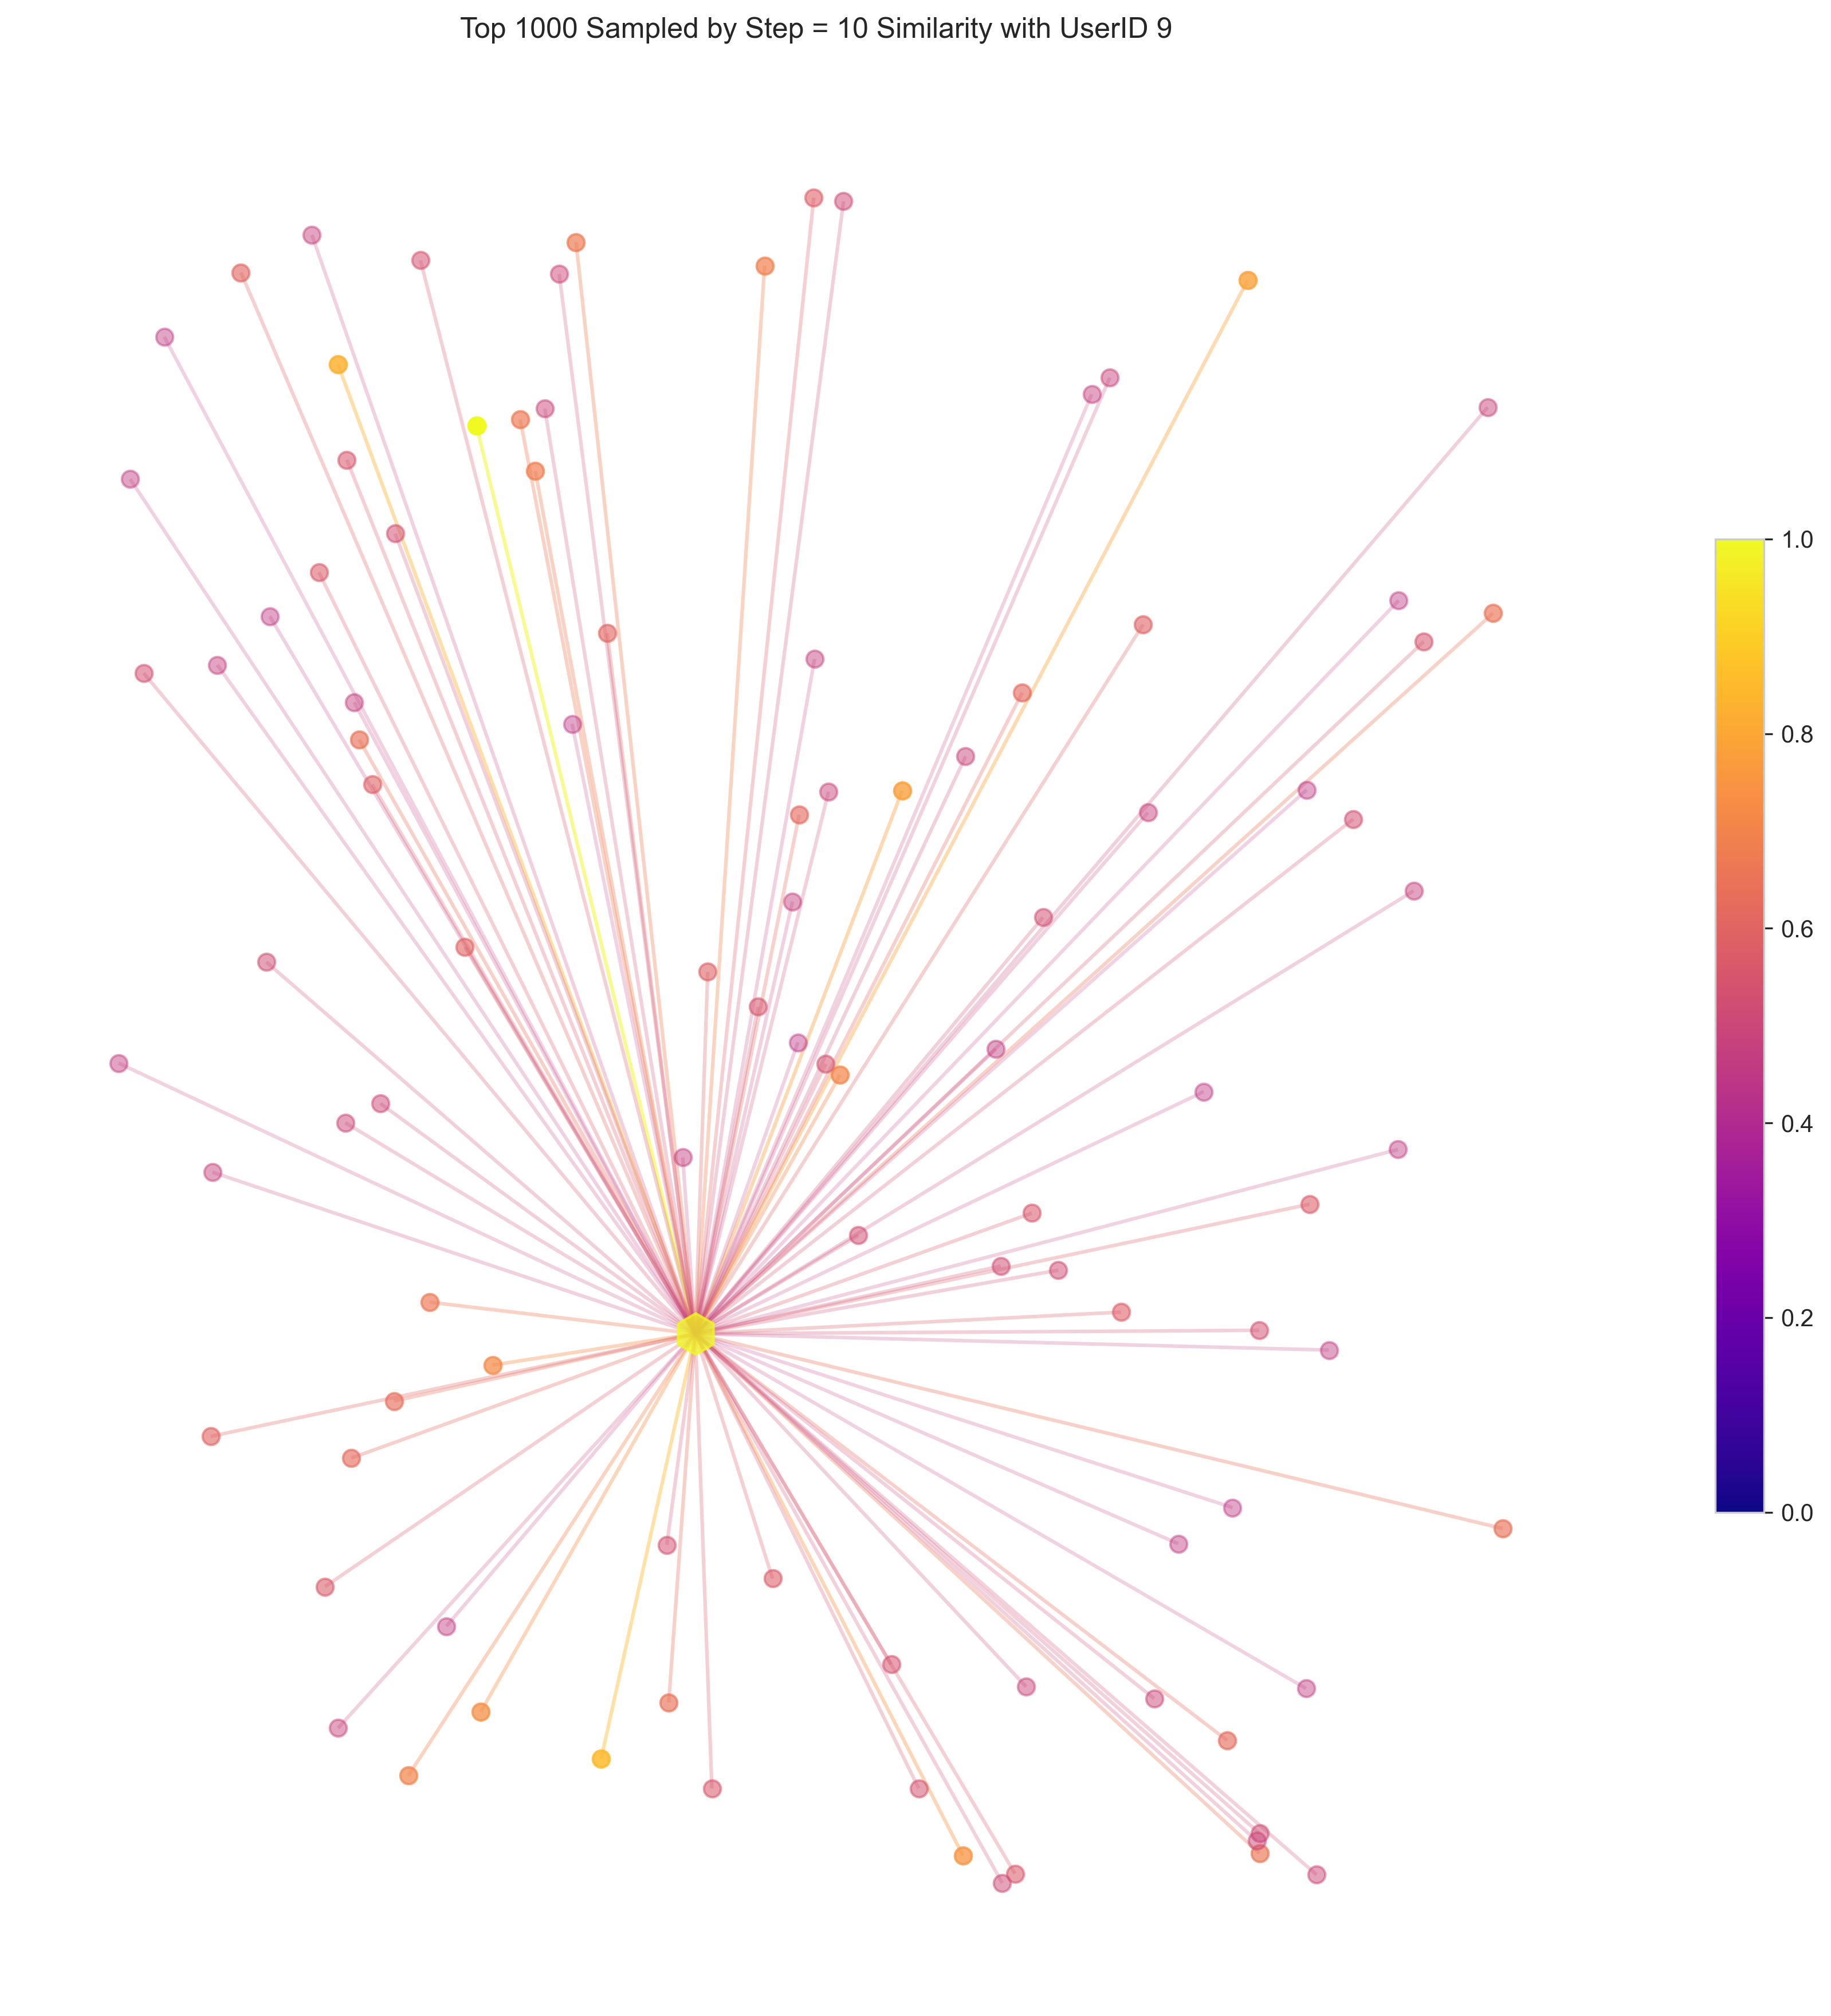

In [9]:
### actual plotting
fig = plt.figure(figsize=figure_size, dpi=figure_dpi)

G = nx.Graph();
G.add_weighted_edges_from([[row["userPair"][0], row["userPair"][1], row["alpha"]]
                           for (index, (idx, row)) in enumerate(df_user_similarity.iterrows())
                           if ((index % sample_step == 0) and (index < max_node_num))])
# [G.add_edge(row["userPair"][0], row["userPair"][1], weight=row["alpha"]) for (idx, row) in df_user_similarity.iterrows() if idx < max_node_num]
# node_pos = nx.spring_layout(G, dim=2) #Any layout will work here, including nx.spring_layout(G)
node_pos = nx.random_layout(G, dim=2)

edges_weights_dict = nx.get_edge_attributes(G, 'weight');

### draw nodes
nx.draw_networkx_nodes(G, pos=node_pos, nodelist=[9], node_shape=core_node_shape, alpha=0.75, node_size=core_node_size, node_color=graph_cmap(1.0));

### draw edges
### loop through edges and draw them
for (key, value) in edges_weights_dict.items():
    nx.draw_networkx_nodes(G, pos=node_pos, nodelist=[key[1]], node_shape=peripheral_node_shape, alpha=value, node_size=peripheral_node_size, node_color=graph_cmap(value));
    nx.draw_networkx_edges(G, pos=node_pos, edgelist=[key], alpha=value*0.5, width=1.5, edge_color=graph_cmap(value))

sm = plt.cm.ScalarMappable(cmap=graph_cmap, norm=plt.Normalize(vmin=0, vmax=1));
sm.set_array([]);
cbar = plt.colorbar(sm, shrink=0.5);

plt.axis('off')
plt.title('Top ' + str(int(max_node_num)) + " Sampled by Step = " + str(int(sample_step)) + ' Similarity with UserID 9')
plt.show()

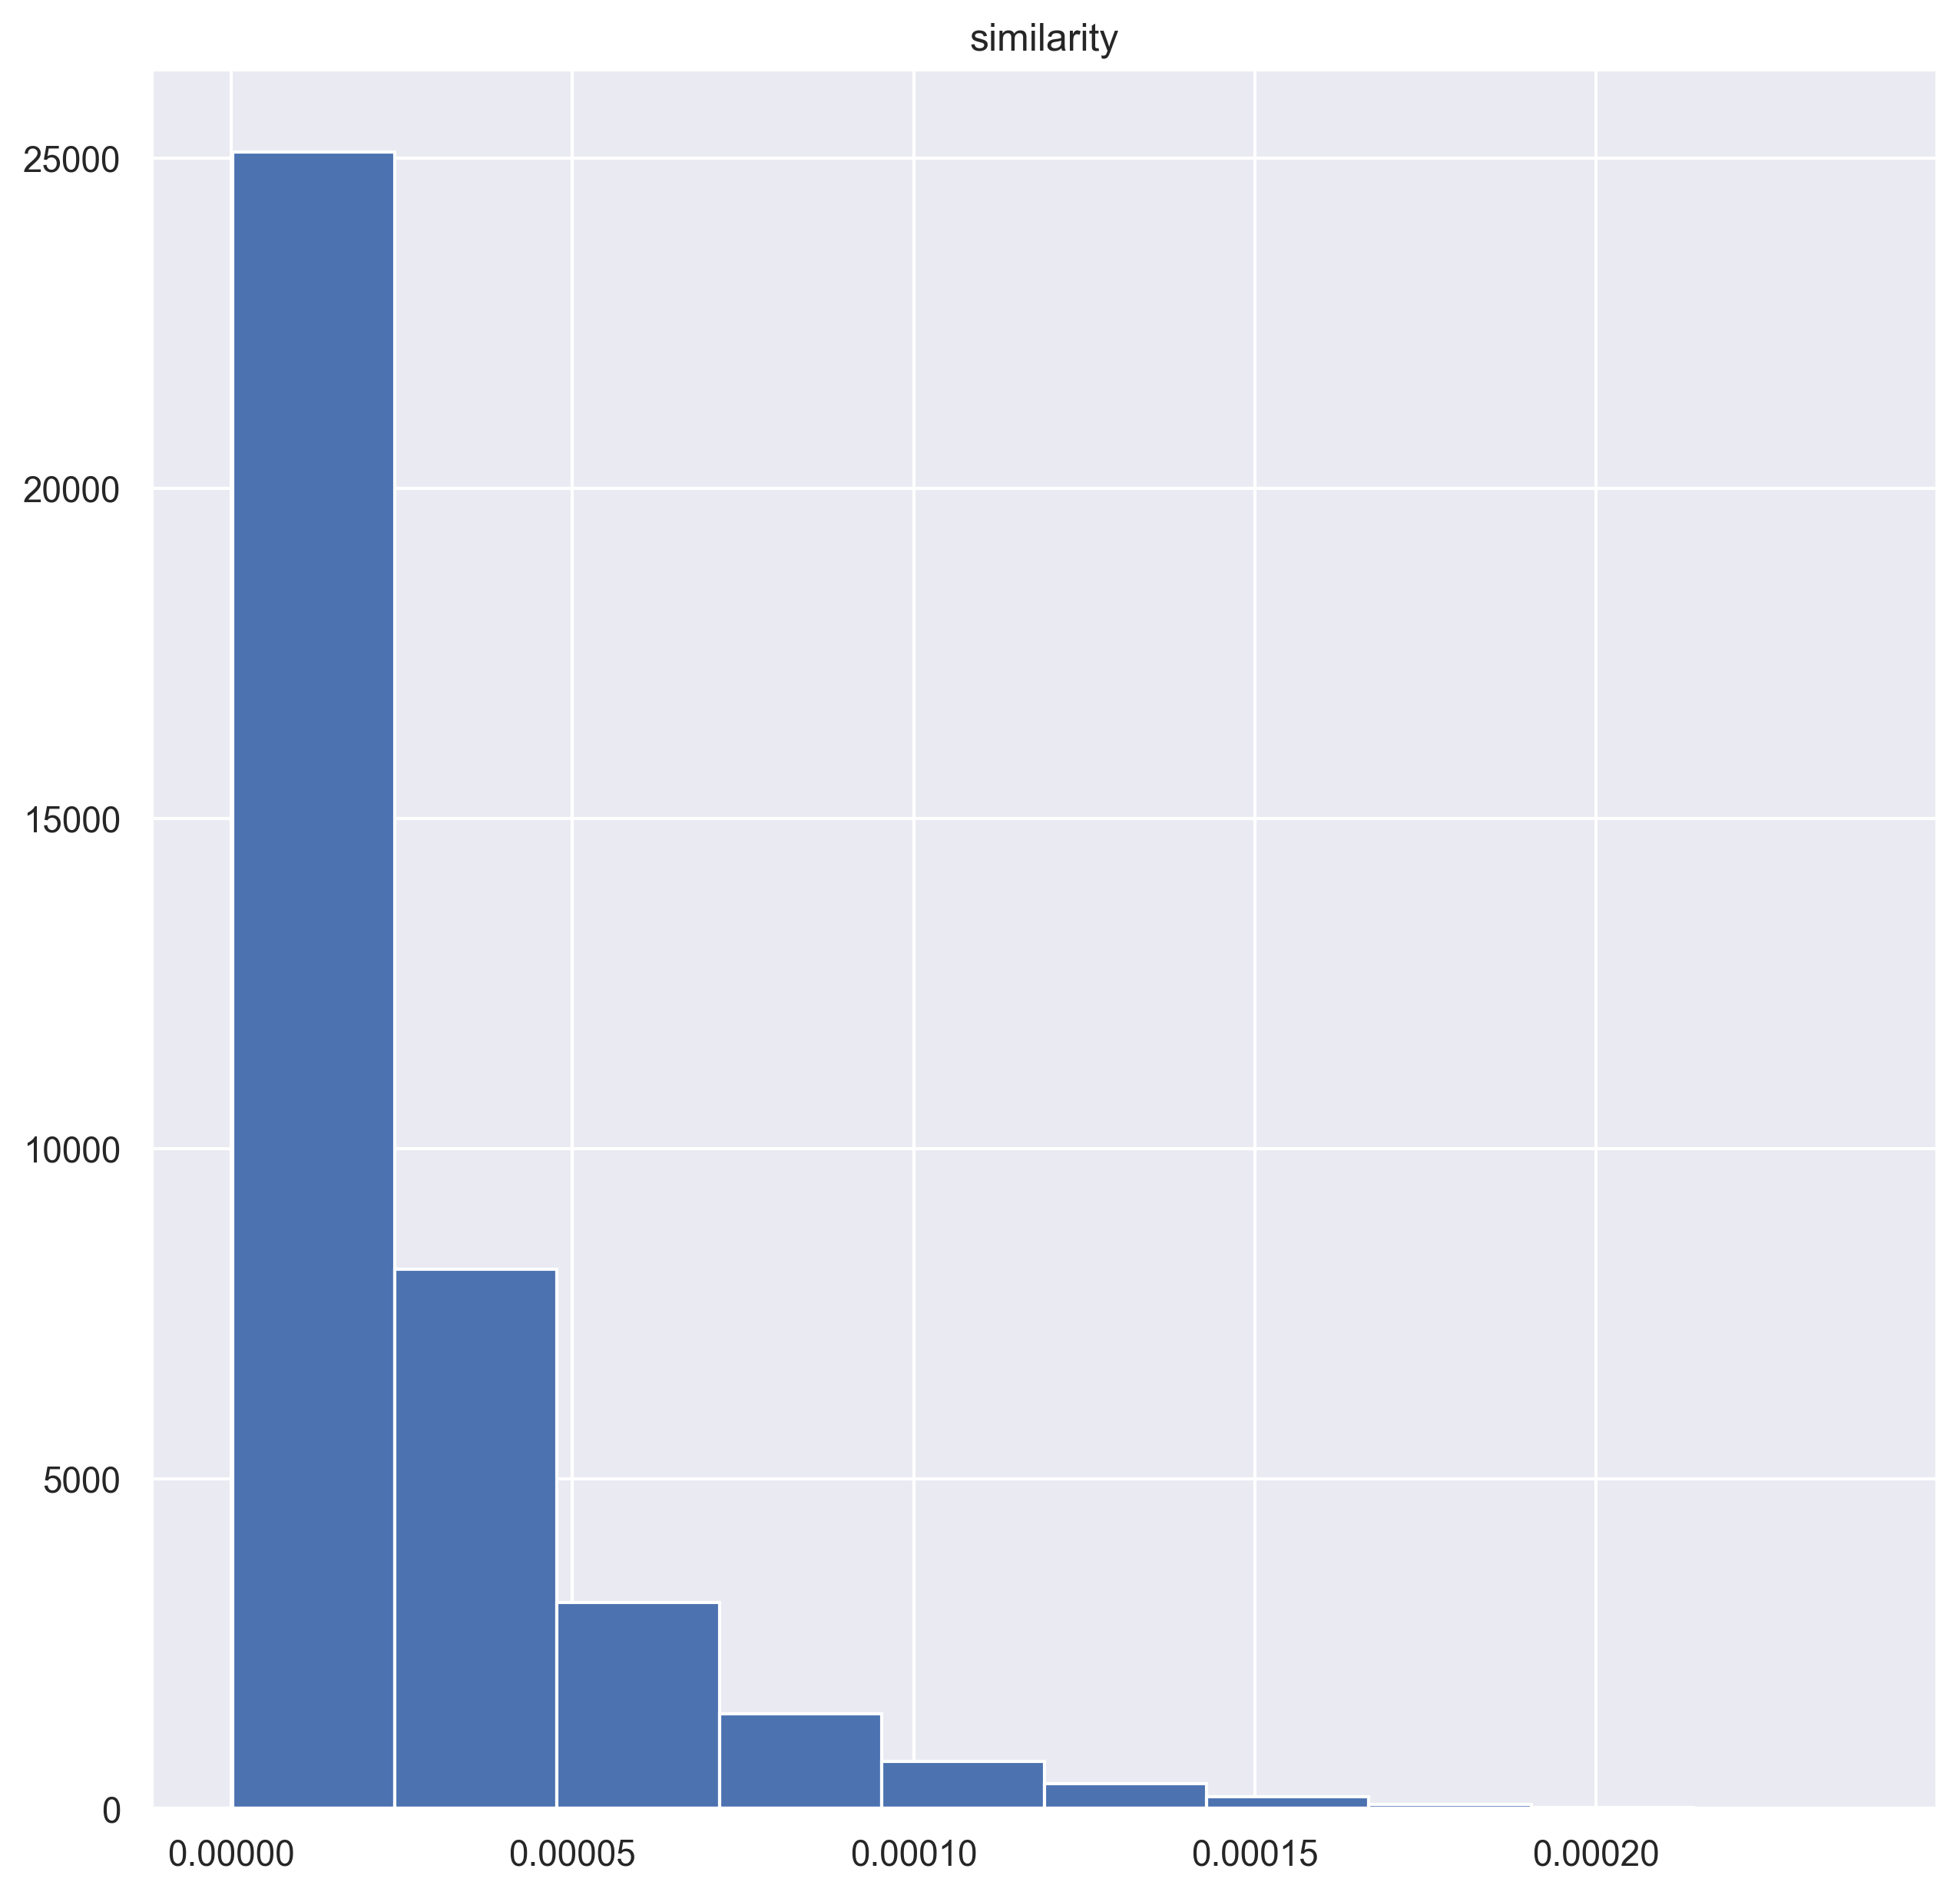

In [31]:
hist = df_user_similarity.hist(column="similarity", bins=10, figsize=(10, 10))

In [25]:
correlation_file_name = "genre_correlation.csv";

In [26]:
df_genre_correlation = pd.read_csv(file_path + correlation_file_name, index_col=0);

The correlation represented by heatmap shows clearly the correlation between different genres.

[Text(0.5, 1.0, 'Genre Correlation')]

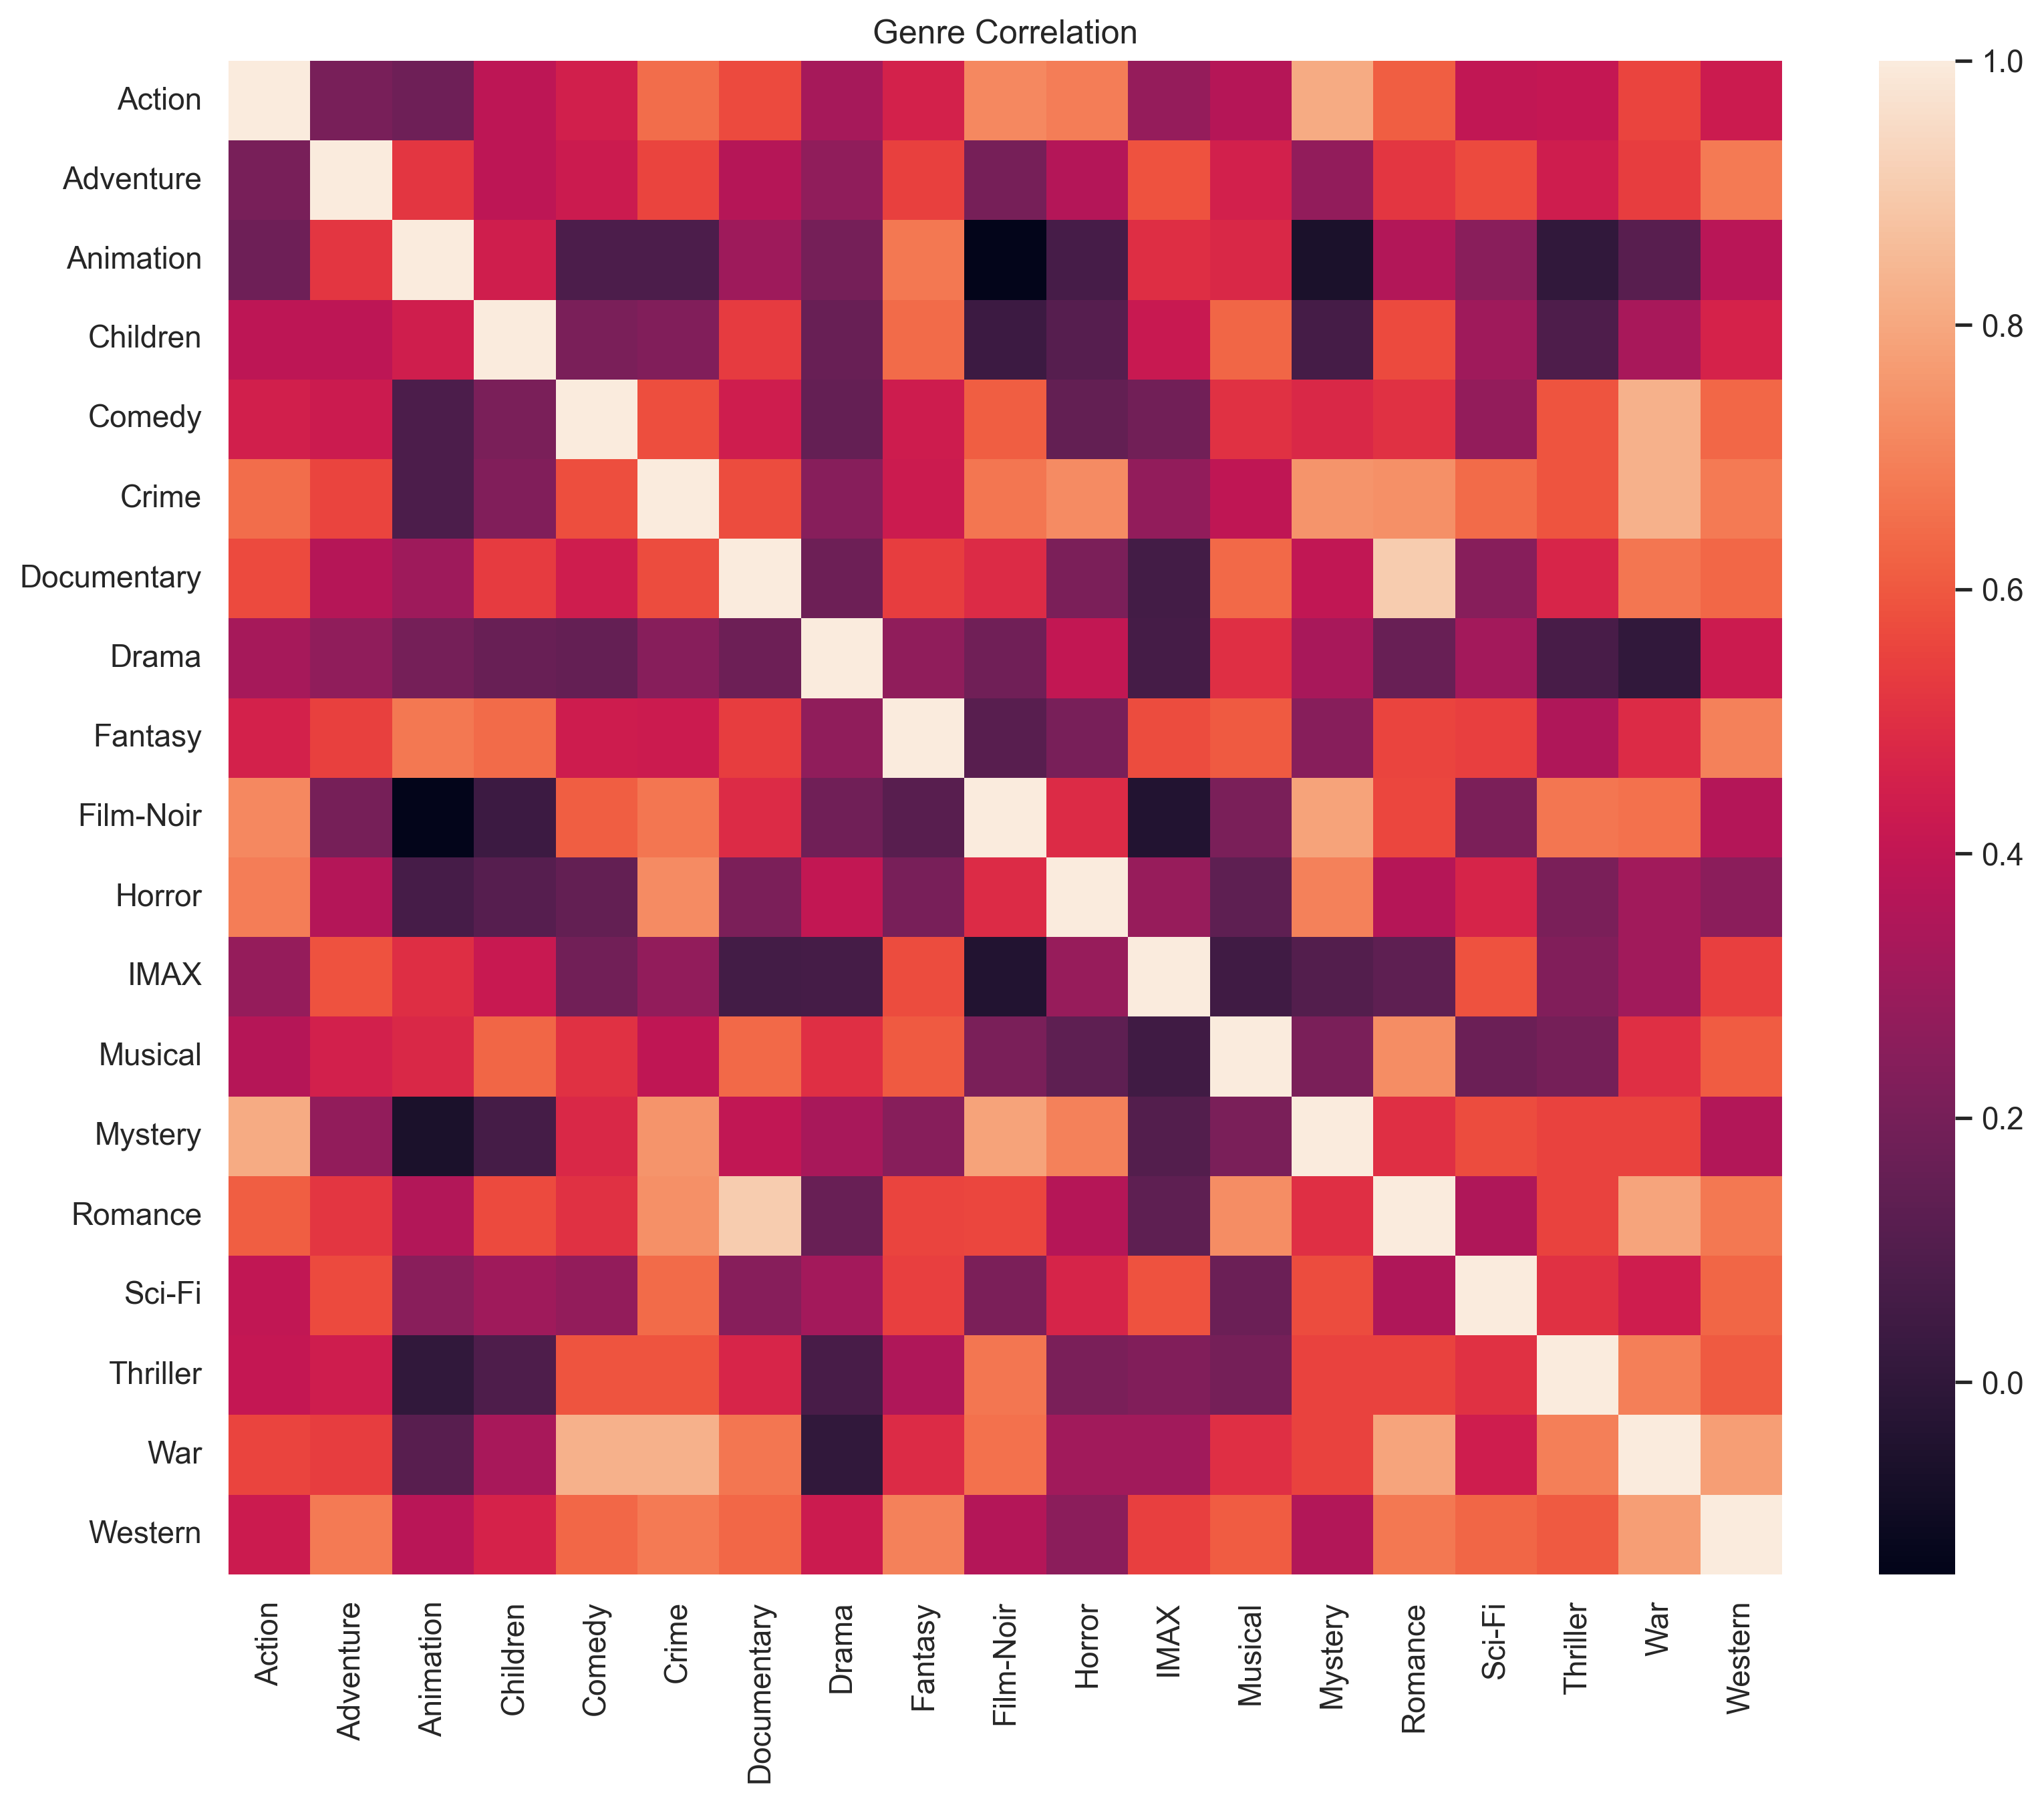

In [12]:
sns.set(rc={'figure.figsize': (12.5, 10), "figure.dpi": 300})
sns.heatmap(df_genre_correlation, annot=False).set(title='Genre Correlation')